# Drivers of Flash Drought in Australia

This code aims to use the methods of Koster $ \textit{et al} $. (2019) to identify flash droughts in South Eastern Australia, and determine what drives them.

#### Flash Drought Defintion 

Flash drought is characterised by the sudden onset and rapid intensification of drought conditions. Following the definition of Koster $ \textit{et al} $. (2019) and in line with BoM - flash drought is definied as a reduction in soil moisture from above the 30th percentile to below its 10th percentile over a period of 20 days. This definition has been chosen for a specific area of analysis, namely SE Australia.  

# Identifying the start of Flash Drought using Soil Moisture Quantiles on one grid cell



In this section, for a given location with latitude and longitude (lat, lon), and a given day (d) of a year (y), the daily 30th and 10th percentiles of soil moisture are constructed. A 5 day window, (d-6, d-3, d, d+3, d+6), is used to construct the distrubution of the two quantiles over a selected period.

The quantiles vary across the period and are plotted together with the actual root zone soil moisture fraction/degree of saturation \textbf{(W)}, in order to identify where flash droughts occur. 

In [1]:
# import all necessary packages 
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
import dask.distributed as dsk

# Start Client/ dask runs together with xarray to improve performance. Only need to initialize once here.
clnt = dsk.Client()
clnt

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41353 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41353/status,
Dashboard: /proxy/41353/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39973,Workers: 7
Dashboard: /proxy/41353/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:41717,Total threads: 1
Dashboard: /proxy/36031/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:34709,


In [2]:
# path to directory of AWRA model data
awra_dir = '/g/data/fj8/BoM/AWRA/DATA/'

In [34]:
# extracting all files of sm_pct data. * tells you to take all similar files, here starting with 1(1980 etc) and 2(2022 etc)
# degree of saturation/soil moisture root zone(0-100cm) fraction (W)
sm_files = 'SCHEDULED-V6/processed/values/day/sm_pct_[1-2]*.nc'

#open a multifile dataset, from the same directory
ds_sm = xr.open_mfdataset(awra_dir + sm_files)

# selecting a time slice and specific latitude and longitude to work on a single grid cell
time_slice = slice('1980-01-01', '2022-12-31')
lat_sel = -36
lon_sel = 148

# data at a grid point and a specific time
da_sm = ds_sm.sel(latitude = lat_sel, longitude = lon_sel, time = time_slice)
da_sm = da_sm.load()

# array of W
W = da_sm['sm_pct']

In [35]:
# creating a function that takes a dataset and creates a 5 day window
# which is a new dimension used for calculating quantiles distribution

def window(dataset):
    
    da_6days_bef = dataset.shift(time = -6) #after
    da_3days_bef = dataset.shift(time = -3)
    da_6days_after = dataset.shift(time = 6) #before
    da_3days_after = dataset.shift(time = 3)
    
    da_list = [da_6days_bef, da_3days_bef, dataset, da_3days_after, da_6days_after]
    
    da_withWindow = xr.concat(da_list, dim = 'window')

    
    return da_withWindow

 

In [36]:
# using the window function to create a window dimension for soil moisture

da_sm_withWindow = window(da_sm)

In [37]:
# using the window created above to calculate the 0.1 and 0.3 quantiles by day of year to identify FD
# create empty lists to save the calculated quantiles

def quantiles_doy(dataset):

    list_da_quant = [] #for quantiles
    list_doy = [] #for dayofyear 
    
    
# for each doy, sample in the new dataset,now including the window, grouped by day of year
# create a list of the quantiles 0.1, 0.3 for each doy, using this window

    for doy, sample in window(dataset).groupby('time.dayofyear'):
        da_quant_bydoy = sample.load().quantile([0.1, 0.3], dim=['time', 'window']) # Need to keep definition of dimension for when working on larger datasets later
        list_doy.append(doy)
        list_da_quant.append(da_quant_bydoy)
    
    ds_pct_perc = xr.concat(list_da_quant, dim = 'dayofyear').assign_coords({'dayofyear': list_doy})
    
    
    return ds_pct_perc

In [38]:
# using the above function to find the two quantiles for each day of the year for soil moisture

ds_sm_pct_perc = quantiles_doy(da_sm_withWindow)

In [39]:
# function that selects one quantile for a data_array

def quantile(dataset, data_array, qtile):
           
    da_yr_doy = dataset['time.dayofyear'].values #get the doy for your original dataset

    # select one quantile from the array, where dayofyear is the same as in the original dataset
    da_quantile = data_array.sel(quantile = qtile, dayofyear = da_yr_doy) 
    
    # rename dimension and reassign original time values
    
    da_quantile = da_quantile.rename({'dayofyear':'time'}).assign_coords({'time': dataset.time.values})

    return da_quantile


In [40]:
# use the quantile function to get a dataset for the 0.1 quantile for soil moisture

da_sm_10p = quantile(da_sm, ds_sm_pct_perc, 0.1)

# and the same for the 0.3 quantile

da_sm_30p = quantile(da_sm, ds_sm_pct_perc, 0.3)

### FD Identification using the 0.1 and 0.3 quantile

Criteria:

$ 1. $ $  \textbf{W} $ has to be above the 30th percentile before the onset of a flash drought $$ $$
$ 2. $ $  \textbf{W} $ then has to drop to 10% after 20 days 

In [41]:
# find the correct treshold for soil moisture percentile/quantile

# criteria 1 : SM above 30%

da_sm_gt_30p = da_sm['sm_pct'].where(da_sm['sm_pct'] >= da_sm_30p)

In [42]:
# criteria 2: SM has to drop below 10% within 20 days 

da_sm_lt_10p = da_sm['sm_pct'].where(da_sm['sm_pct'] <= da_sm_10p)

# bring the values forward 20 days, so we can check where they match with the first criteria
# days where they do not are nan
da_sm_after_20days_lt_10p = da_sm_lt_10p.shift(time = -20)

In [43]:
# Need a dataset that meets both the criteria

da_sm_flash_drght = da_sm_gt_30p.where(~np.isnan(da_sm_after_20days_lt_10p)) 


# check if there are any values which corresponds to the onset of a flash drought

da_sm_flash_drght.dropna(dim = 'time')

<xarray.Dataset>
Dimensions:    (time: 187)
Coordinates:
  * time       (time) datetime64[ns] 1980-02-02 1980-02-03 ... 2020-07-24
    latitude   float64 -36.0
    longitude  float64 148.0
Data variables:
    sm_pct     (time) float32 0.08126 0.09517 0.0892 ... 0.3523 0.3458 0.339

Text(0.5, 0, 'Time')

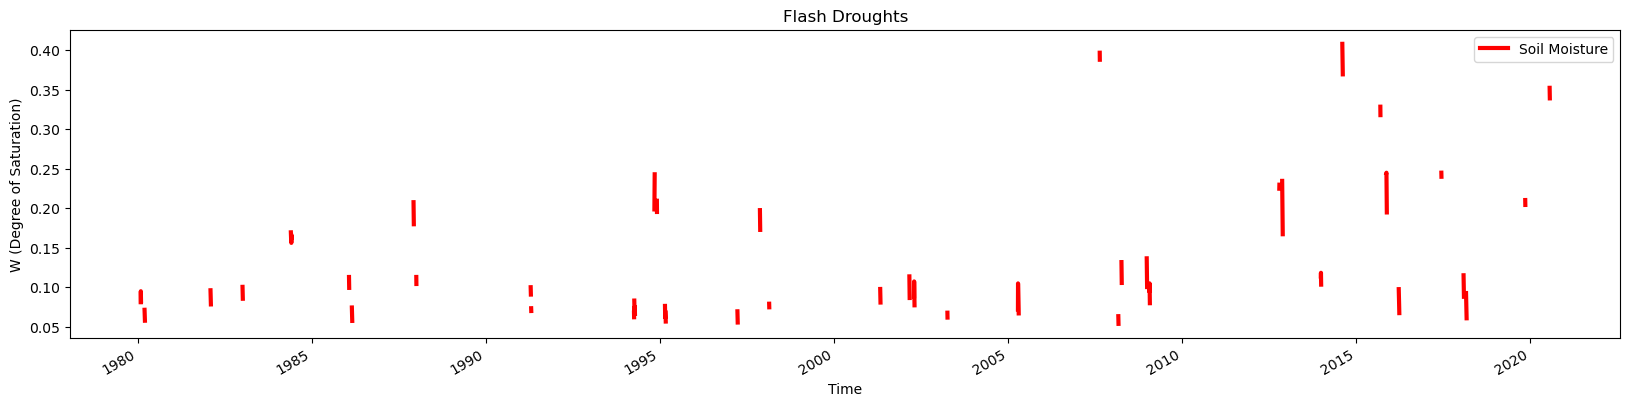

In [44]:
# plot of the flash drought events for a selected time slice 
da_sm_flash_drght['sm_pct'].sel(time = time_slice).plot(size = 4, aspect= 5, linewidth = '3', linestyle = 'solid', c = 'r', label = 'Soil Moisture')
plt.legend()
plt.title('Flash Droughts') 
plt.ylabel('W (Degree of Saturation)')
plt.xlabel('Time')

The plot above contains all possible start dates for a flash drought, that meet the criteria:

$ 1. $ $  \textbf{W} $ has to be above the 30th percentile before the onset of a flash drought $$ $$
$ 2. $ $  \textbf{W} $ then has to drop to 10% after 20 days 

Since we have multiple consecutive possible start dates, we need to further filter these using criteria for evapotransporation.


In [46]:
# save the calculated FD start day data to a netcdf file for future use

out_dir = '/g/data/w97/aj8747/fd_summer_project/'
out_file = 'fd_sm_start.nc'
da_sm_flash_drght.to_netcdf(out_dir + out_file)

In [47]:
# the flash drought period lasts 20 days from the onset of a flash drought

# to identify flash drought end days, shift the start days 20 days

fd_end = da_sm_flash_drght.shift( time = 20)


In [48]:
# save the calculated FD end day data to a netcdf file for future use


out_dir = '/g/data/w97/aj8747/fd_summer_project/'
out_file = 'fd_sm_end.nc'
fd_end.to_netcdf(out_dir + out_file)